In [1]:
#所有程序第一步
#对用户和音乐分类
#音乐分成操作次数小于10的和操作次数大于10的，根据分布直方图设置门限
##                  再进一步分成热门歌曲和一般歌曲
#用户分成操作次数大于35的和操作次数小于35的，根据分布直方图设置门限
##                  再进一步分成超活跃用户和一般用户

In [44]:
#导入库
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sbn
import collections
import seaborn as sbn
from scipy.stats import kstest
from sklearn.model_selection import StratifiedShuffleSplit,ShuffleSplit
from sklearn.model_selection import train_test_split
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [6]:
#输入文件
DATA= os.path.join(os.getcwd(),'data')
MEMBER = os.path.join(DATA,'member_done.csv')
SONG = os.path.join(DATA,'song_done.csv')
TRAIN = os.path.join(DATA,'train_done.csv')

In [53]:
#输出文件
SONG_CNT_UP = os.path.join(DATA,'song_cnt_up.xls')
MEM_CNT_UP = os.path.join(DATA,'mem_cnt_up.xls')

In [9]:
#读取文件
mem = pd.read_csv(MEMBER)
song = pd.read_csv(SONG)
train = pd.read_csv(TRAIN)

In [13]:
#不用用户日志信息
#只筛选用户元信息有的东西
mem = mem[['msno','city','bd','registered_via','registration_init_time','mem_cnt','mem_re_cnt','re_rate']]
mem[:5]

,msno,city,bd,registered_via,registration_init_time,mem_cnt,mem_re_cnt,re_rate
0,12143,1,0,7,20110820,668,560,0.838323
1,18429,1,0,7,20160130,117,8,0.068376
2,16686,1,0,7,20110111,314,152,0.484076
3,19934,1,0,7,20160217,57,10,0.175439
4,6311,12,28,9,20060531,84,17,0.202381


In [12]:
train[:5]

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,5833,6250,explore,Explore,online-playlist,1
1,5833,2762,explore,Explore,online-playlist,1
2,5833,2514,explore,Explore,online-playlist,1
3,12306,15960,my library,Local playlist more,local-playlist,1
4,5833,18592,explore,Explore,online-playlist,1


In [11]:
song[:5]

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,song_cnt,song_re_cnt,re_rate,name,song_year,country,company
0,24521,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,2893,1827,0.631524,PLAYING WITH FIRE,NaN,NaN,NaN
1,7504,231781,465,SUPER JUNIOR,NaN,NaN,31.0,305,145,0.475410,SORRY| SORRY,NaN,NaN,NaN
2,19516,273554,465,S.H.E,湯小康,徐世珍,3.0,318,160,0.503145,愛我的資格,2002.0,TW,C95
3,16105,140329,726,貴族精選,Traditional,Traditional,52.0,57,35,0.614035,Mary Had a Little Lamb,NaN,NaN,NaN
4,11874,226220,458,伍佰 & China Blue,Jonathan Lee,NaN,3.0,568,320,0.563380,夢醒時分,2011.0,TW,H95


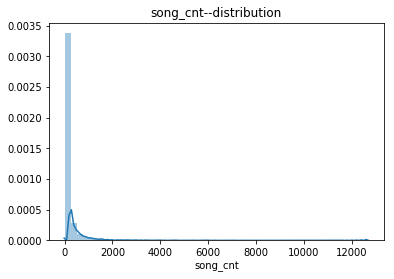

In [16]:
#音乐分类
#因为筛选之后只有播放次数大于10的，所以先对这个分类
#绘制播放次数的分布直方图
sbn.distplot(song['song_cnt'].dropna())
plt.title(('song_cnt--distribution'))
plt.show()


In [27]:
song_cnt_sum = song['song_cnt'].sum()
print(song_cnt_sum)
#提取歌曲id和播放次数
song_cnt = song[['song_id','song_cnt']]
#统计播放次数的出现的次数，以及对应的播放贡献率
song_cnt_cnt = song_cnt.groupby(by = 'song_cnt').count()['song_id'].to_dict()
#播放次数出现的次数
song_cnt['song_cnt_cnt'] = song_cnt['song_cnt'].apply(lambda x : int(song_cnt_cnt[x]))
#统计每个类别的播放次数
song_cnt['song_cnt_bo_cnt'] = song_cnt['song_cnt'].apply(lambda x : int(x)*int(song_cnt_cnt[x]))
#song_cnt只保留一个
song_cnt.drop_duplicates('song_cnt','last',inplace = True)
#song_cnt升序排列
song_cnt_up = song_cnt.sort_values(by = 'song_cnt',ascending = True)
song_cnt_up[:5]
#保存文件
#播放次数对应的歌曲数量和每个类别总的播放次数
song_cnt_up.to_excel(SONG_CNT_UP,index = False)

6084814


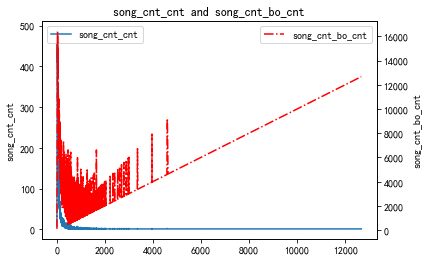

In [50]:
#绘制播放次数对应的歌曲数量，以及对应的播放率
x = song_cnt_up['song_cnt']
y1 = song_cnt_up['song_cnt_cnt']
y2 = song_cnt_up['song_cnt_bo_cnt']
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x, y1)
ax1.set_ylabel('song_cnt_cnt')
ax1.set_title("song_cnt_cnt and song_cnt_bo_cnt")
ax1.legend(loc = 2)  #显示标签
ax2 = ax1.twinx()  # this is the important function
ax2.plot(x, y2, '-.',c = 'red')
ax2.set_ylabel('song_cnt_bo_cnt')
ax2.set_xlabel('song_cnt')
ax2.legend(loc = 1)  #显示标签
plt.show()


In [54]:
#用户分类
mem_cnt_sum = mem['mem_cnt'].sum()
print(mem_cnt_sum)
mem_cnt = mem[['msno','mem_cnt']]
#统计播放次数的出现的次数，以及对应的播放贡献率
mem_cnt_cnt = mem_cnt.groupby(by = 'mem_cnt').count()['msno'].to_dict()
#播放次数出现的次数
mem_cnt['mem_cnt_cnt'] = mem_cnt['mem_cnt'].apply(lambda x : int(mem_cnt_cnt[x]))
#统计每个类别的播放次数
mem_cnt['mem_cnt_bo_cnt'] = mem_cnt['mem_cnt'].apply(lambda x : int(x)*int(mem_cnt_cnt[x]))
#mem_cnt只保留一个
mem_cnt.drop_duplicates('mem_cnt','last',inplace = True)
#mem_cnt升序排列
mem_cnt_up = mem_cnt.sort_values(by = 'mem_cnt',ascending = True)

#保存文件
#播放次数对应的用户数量和每个类别总的播放次数
mem_cnt_up.to_excel(MEM_CNT_UP,index = False)
mem_cnt_up[:5]

7265352


D:\Users\10100\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Users\10100\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Users\10100\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,msno,mem_cnt,mem_cnt_cnt,mem_cnt_bo_cnt
21842,12274,36,120,4320
21479,17883,37,116,4292
21176,14153,38,104,3952
21948,2291,39,122,4758
21903,15554,40,101,4040


In [59]:
print(mem_cnt_up['mem_cnt_cnt'].sum())
print(mem_cnt_up['mem_cnt_bo_cnt'].sum())
print(str(932/21965))
print(str(1314743/len(train)))

21965
7265352
0.04243114045071705
0.2160695462507153


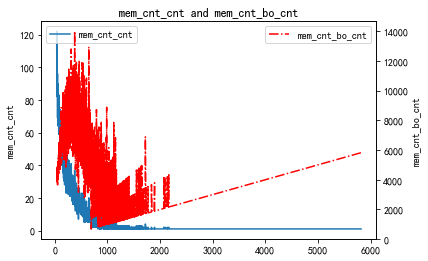

In [56]:
#绘制播放次数对应的歌曲数量，以及对应的播放率
x = mem_cnt_up['mem_cnt']
y1 = mem_cnt_up['mem_cnt_cnt']
y2 = mem_cnt_up['mem_cnt_bo_cnt']
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x, y1)
ax1.set_ylabel('mem_cnt_cnt')
ax1.set_title("mem_cnt_cnt and mem_cnt_bo_cnt")
ax1.legend(loc = 2)  #显示标签
ax2 = ax1.twinx()  # this is the important function
ax2.plot(x, y2, '-.',c = 'red')
ax2.set_ylabel('mem_cnt_bo_cnt')
ax2.set_xlabel('mem_cnt')
ax2.legend(loc = 1)  #显示标签
plt.show()


KeyError: 'song_cnt'